In [1]:
# Import necessary libraries
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch.nn as nn
import torch.optim as optim
import string
from imblearn.over_sampling import SMOTE

In [2]:
data=pd.read_csv('D:\projects\Gen_Flask\YoutubeCommentsDataSet.csv')
data.head()

,Comment,Sentiment
0,lets not forget that apple pay in 2014 require...,neutral
1,here in nz 50 of retailers don’t even have con...,negative
2,i will forever acknowledge this channel with t...,positive
3,whenever i go to a place that doesn’t take app...,negative
4,apple pay is so convenient secure and easy to ...,positive


In [3]:
print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18408 entries, 0 to 18407
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Comment    18364 non-null  object
 1   Sentiment  18408 non-null  object
dtypes: object(2)
memory usage: 287.8+ KB
None


In [4]:
# Drop rows with missing comments
data = data.dropna(subset=['Comment'])
print("After dropping missing comments:", data.shape)

After dropping missing comments: (18364, 2)


In [5]:
import re

def preprocess_text(text):
    text = text.lower()  # normalize text
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # remove URLs
    text = re.sub(r'\W', ' ', text)  # remove non-word characters
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces
    return text

# Apply preprocessing on the Comment column
data['clean_text'] = data['Comment'].apply(preprocess_text)
print(data[['Comment', 'clean_text']].head())


                                             Comment  \
0  lets not forget that apple pay in 2014 require...   
1  here in nz 50 of retailers don’t even have con...   
2  i will forever acknowledge this channel with t...   
3  whenever i go to a place that doesn’t take app...   
4  apple pay is so convenient secure and easy to ...   

                                          clean_text  
0  lets not forget that apple pay in 2014 require...  
1  here in nz 50 of retailers don t even have con...  
2  i will forever acknowledge this channel with t...  
3  whenever i go to a place that doesn t take app...  
4  apple pay is so convenient secure and easy to ...  


In [6]:
import transformers
import accelerate

print(transformers.__version__)
print(accelerate.__version__)


4.49.0
1.4.0


In [7]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("mrm8488/t5-base-finetuned-emotion")
model = AutoModelForSeq2SeqLM.from_pretrained("mrm8488/t5-base-finetuned-emotion")

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [8]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [9]:
# Function to predict emotion using T5 model
def get_emotion_t5(text):
    try:
        input_text = f"emotion: {text}"
        inputs = tokenizer(input_text, return_tensors="pt", truncation=True).to(device)
        outputs = model.generate(**inputs, max_length=10)
        emotion = tokenizer.decode(outputs[0], skip_special_tokens=True)
        return emotion
    except Exception as e:
        print(f"Error: {e}")
        return "unknown"

# Generate emotions for each comment
data['predicted_emotion'] = data['clean_text'].apply(get_emotion_t5)


In [11]:
# Save the updated DataFrame to a new CSV file
data.to_csv("YoutubeCommentsDataSet_with_emotion.csv", index=False)
print("CSV file saved as 'YoutubeCommentsDataSet_with_emotion.csv'")

CSV file saved as 'YoutubeCommentsDataSet_with_emotion.csv'


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [13]:
data=pd.read_csv("D:\GitHub\GenSent-AI-Powered-YouTube-Insights\services\YoutubeCommentsDataSet_with_emotion.csv")


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18364 entries, 0 to 18363
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Comment            18364 non-null  object
 1   Sentiment          18364 non-null  object
 2   clean_text         18364 non-null  object
 3   predicted_emotion  18364 non-null  object
dtypes: object(4)
memory usage: 574.0+ KB


In [15]:
# Prepare data for SMOTE
X = data['clean_text']
y = data['predicted_emotion']


In [16]:
# Encode labels
y_encoded = pd.factorize(y)[0]

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Convert text to numerical features using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X).toarray()


In [18]:
print(pd.Series(y_encoded).value_counts())


0    12484
3     2019
2     1543
5      926
1      846
4      544
6        2
Name: count, dtype: int64


In [20]:
from imblearn.over_sampling import RandomOverSampler

# Apply RandomOverSampler to balance classes
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_tfidf, y_encoded)

In [21]:
# Decode labels back
y_resampled_labels = pd.factorize(y)[1][y_resampled]


In [22]:
# Create balanced DataFrame
balanced_data = pd.DataFrame({
    'Comment': [' '.join(words) for words in vectorizer.inverse_transform(X_resampled)],
    'predicted_emotion': y_resampled_labels
})

# Save balanced dataset
balanced_data.to_csv("YoutubeComments_Balanced.csv", index=False)

print("Step 2: RandomOverSampler balancing completed and dataset saved!")

Step 2: RandomOverSampler balancing completed and dataset saved!


In [23]:
# MLP Model Definition
class EmotionMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(EmotionMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


In [24]:
# Prepare data for training
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [36]:
input_size = X_train.shape[1]
hidden_size = 512
output_size = len(np.unique(y_resampled))

mlp_model = EmotionMLP(input_size, hidden_size, output_size).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

Epoch [1/100], Loss: 1.9455
Epoch [2/100], Loss: 1.9379
Epoch [3/100], Loss: 1.9302
Epoch [4/100], Loss: 1.9220
Epoch [5/100], Loss: 1.9130
Epoch [6/100], Loss: 1.9031
Epoch [7/100], Loss: 1.8923
Epoch [8/100], Loss: 1.8806
Epoch [9/100], Loss: 1.8680
Epoch [10/100], Loss: 1.8544
Epoch [11/100], Loss: 1.8399
Epoch [12/100], Loss: 1.8244
Epoch [13/100], Loss: 1.8081
Epoch [14/100], Loss: 1.7909
Epoch [15/100], Loss: 1.7728
Epoch [16/100], Loss: 1.7538
Epoch [17/100], Loss: 1.7341
Epoch [18/100], Loss: 1.7135
Epoch [19/100], Loss: 1.6921
Epoch [20/100], Loss: 1.6700
Epoch [21/100], Loss: 1.6471
Epoch [22/100], Loss: 1.6234
Epoch [23/100], Loss: 1.5990
Epoch [24/100], Loss: 1.5740
Epoch [25/100], Loss: 1.5483
Epoch [26/100], Loss: 1.5220
Epoch [27/100], Loss: 1.4951
Epoch [28/100], Loss: 1.4677
Epoch [29/100], Loss: 1.4398
Epoch [30/100], Loss: 1.4114
Epoch [31/100], Loss: 1.3827
Epoch [32/100], Loss: 1.3537
Epoch [33/100], Loss: 1.3243
Epoch [34/100], Loss: 1.2948
Epoch [35/100], Loss: 1

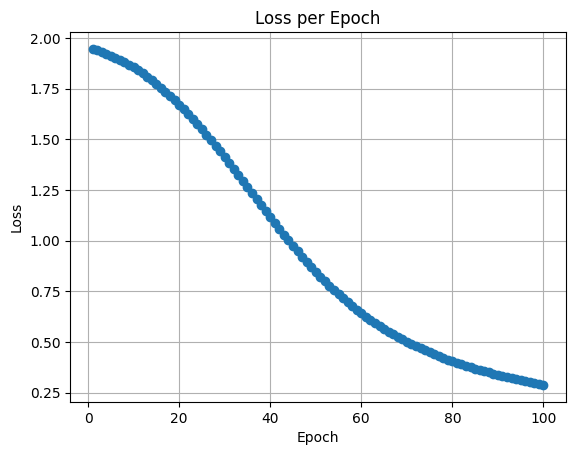

In [37]:
import matplotlib.pyplot as plt

# List to store loss values for each epoch
loss_values = []

# Training loop
num_epochs = 100  # Make sure this is defined correctly
for epoch in range(num_epochs):
    mlp_model.train()

    inputs = torch.tensor(X_train, dtype=torch.float32).to(device)
    labels = torch.tensor(y_train, dtype=torch.long).to(device)

    outputs = mlp_model(inputs)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Record the loss at each epoch
    loss_values.append(loss.item())

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# After training, plot the loss
plt.plot(range(1, num_epochs + 1), loss_values, marker='o')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


In [67]:
# Evaluate the model
mlp_model.eval()
with torch.no_grad():
    inputs = torch.tensor(X_test, dtype=torch.float32).to(device)
    labels = torch.tensor(y_test, dtype=torch.long).to(device)

    outputs = mlp_model(inputs)
    predictions = torch.argmax(outputs, dim=1).cpu().numpy()


    

In [68]:
from sklearn.metrics import accuracy_score, classification_report
print("Accuracy:", accuracy_score(y_test, predictions))
print("Classification Report:\n", classification_report(y_test, predictions))


Accuracy: 0.9177823549605219
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.70      0.77      2439
           1       0.93      0.98      0.96      2472
           2       0.89      0.91      0.90      2542
           3       0.88      0.87      0.87      2470
           4       0.95      1.00      0.97      2470
           5       0.91      0.95      0.93      2526
           6       1.00      1.00      1.00      2559

    accuracy                           0.92     17478
   macro avg       0.92      0.92      0.91     17478
weighted avg       0.92      0.92      0.92     17478



In [69]:
import os
import pickle

# Define the folder path where you want to save the model
model_folder = "model"
os.makedirs(model_folder, exist_ok=True)

# Save the TF-IDF vectorizer
with open(os.path.join(model_folder, "tfidf_vectorizer.pkl"), "wb") as f:
    pickle.dump(vectorizer, f)

# Save emotion labels
emotion_labels = pd.factorize(y)[1]  # This is already in your code for prediction
with open(os.path.join(model_folder, "emotion_labels.pkl"), "wb") as f:
    pickle.dump(emotion_labels, f)

# Your existing model saving code
model_path = os.path.join(model_folder, "emotion_mlp_model.pth")
torch.save(mlp_model.state_dict(), model_path)

In [70]:
# Sample new comments
new_comments = ["damn you shit, you are happy now", "This is so boring.", "Amazing content, great work!", "I'm really sad."]

# Preprocess the new comments
new_comments_clean = [preprocess_text(comment) for comment in new_comments]

# Transform the new comments using the trained TF-IDF vectorizer
new_comments_tfidf = vectorizer.transform(new_comments_clean).toarray()


In [71]:
# Convert to torch tensor
inputs = torch.tensor(new_comments_tfidf, dtype=torch.float32).to(device)

# Get model predictions
with torch.no_grad():
    outputs = mlp_model(inputs)
    predictions = torch.argmax(outputs, dim=1).cpu().numpy()

# Decode predictions back to emotion labels
emotion_labels = pd.factorize(y)[1]  # Using the same factorized labels as before
predicted_emotions = emotion_labels[predictions]

# Display the predictions
for comment, emotion in zip(new_comments, predicted_emotions):
    print(f"Comment: {comment}\nPredicted Emotion: {emotion}\n")


Comment: damn you shit, you are happy now
Predicted Emotion: joy

Comment: This is so boring.
Predicted Emotion: sadness

Comment: Amazing content, great work!
Predicted Emotion: surprise

Comment: I'm really sad.
Predicted Emotion: sadness

